# FoodEase Datascience Project
-------
**By: Christina Holman, Earn Khunpinit, Lee Ann Song, and Sai Wang**

## Problem Setup
----

Victims of natural didasters have difficulty receiving and sharing fresh food,
clean water, and other supplies because people don't always know where local
resources are stored, and those who have resources don't know where those 
resources are needed. By directly analyzing twitter posts we can get an 
understanding ofwhat is needed and where - allowing for those local resources 
to be used more efficiently. 

**Dataset:** In this project we are taking an array of tweets that contain 
vocabulary pertaining to disasters; some of which refer to actual disasters
and other refer to disaster movies, books, and other such things. 

**Goal:** To determine which tweets really are about disasters, and which are
not, and based on those tweets determine where approximately the disaster has occurred. 

**SETUP BEFORE CODE**: Please pip install the following packages:
- pip install ipyleaflet
- pip install --upgrade folium
- pip install geopandas
- pip install geopy
- npm install --save leaflet-search

### Imports

In [2]:
import numpy as np # matrix manipulation
import pandas as pd # dataset management 
import matplotlib as mpl # plots
import matplotlib.pyplot as plt # moar plots
import scipy as sp # science

# import sklearn
# model checking
from sklearn.metrics import log_loss, confusion_matrix

# natural language processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

# adding model types
from sklearn.linear_model import LogisticRegression
from sklearn.tree         import DecisionTreeClassifier

#import GIS visualization
from ipyleaflet import *
import ipyleaflet as leaf
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from ipywidgets import HTML

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Loading Datasets

In [3]:
# original data.
# ** Note: We won't actually use this
original = pd.read_csv('data/original.csv', encoding='ISO-8859-1') # uncleaned raw source information

test  = pd.read_csv('data/test.csv').set_index('id')  # contains x only

# contains y and x - we later split this into training and validation sets
train_and_validation = pd.read_csv('data/train.csv').set_index('id') 

locations = pd.read_csv('data/geodata.csv').set_index('id') # cleaned location data

In [4]:
def add_locations(df):
    for column in locations: df[column] = np.nan
    df.update(locations)
    
add_locations(test)
add_locations(train_and_validation)

In [5]:
x_train_and_validation = train_and_validation.drop(columns='target') # everything but the target
y_train_and_validation = train_and_validation.target # 1 means it's a real disaster tweet

x_test  = test # test set x values

### Splitting Dataset

In order to test the accuracy of our algorithm on information not used to train on,
we choose to split our information into a training and validation set. This training
set we will use to fit our model, and the validation set will be used to predict
how our algorithm will work on the test set.

``` x_train, y_train ``` will be our training dataset

``` x_valid, y_valid ``` will be our validation set

As well, note that the input to our function is `x_train_and_validation.text.values`. 
This provides a numpy array with all the text entries of the data. This does not 
reorder the rows, so the y and x arrays are still in sync.

In [6]:
frac_test = 0.2

# splitting the dataset
x_train_df, x_valid_df, y_train, y_valid = train_test_split(x_train_and_validation, 
                                                      y_train_and_validation.values,
                                                      stratify=y_train_and_validation.values, 
                                                      random_state=53,test_size=frac_test, shuffle=True)


# Note:
# we are keeping `x_valid_df` and `x_train_df` as dataframes so 
# we can use the validation set locations later. Here we reduce
# them to just their text values
x_train, x_valid = x_train_df.text.values, x_valid_df.text.values

## Dataset Analysis - *Is the tweet about a disaster?*

### Initial Observations

In [7]:
frac_true = sum(y_train_and_validation)/len(y_train_and_validation)

# fraction that are disaster tweets
print('Percent True:  {:.2f}%'.format(frac_true*100))\

# fraction that are not disaster tweets
print('Percent False: {:.2f}%'.format((1-frac_true)*100))

Percent True:  42.97%
Percent False: 57.03%


**Note:**
The dataset we're using is `42.97%` positive and `57.03%` negative. 
What this means is that a classifier which always predicts that the
tweet is *not* about a disaster would have a ~57% accuracy. This would
not be useful for any practical context, but is the score the beat.

## Machine Learning Setup

### Natural Language Processing

The classification algorithms we covered in class took numeric data and 
used that information to classify different entries based on which numbers
were the most meaningful. In fact using numbers with specific meaning 
to determine which class of *thing* any input is... is the only way to classify
*anything*. 

Unfortunately when it comes to sentences or strings like the tweets we're looking 
at in this project, the literal strings of text individually contain very little
classifyable meaning. As in, it makes little to no sense to try and predict 
if the tweet is about a disaster based on whether the fifth letter in that tweet
is an `'a'` or a `'b'`. What we want is a list of useful numeric values that indicate
something about the nature of the sentence, or how the sentences differ from
eachother. **So how do we get that?** 

For this project we're using vectorizers. Vectorizors take a list of inputs
and based on that list comes up with a list of useful numbers for each entry
that help differentiate them in a meaningful way. First, we set up our
information gathering function below.

In [8]:
def log_loss_from_vectorizer (model, vectorizer, 
                              x_train, y_train, x_valid, y_valid):
    ''' Take a training and validation dataset and run those against a
    model and vectorizer. Return a set of basic analytics of the model
    on the dataset.
    
    Args
    ----
   
    model : a machine learning model that when fit to a vector produced
        by the vectorizer above can classify a model into the y_values
        provided
        
    vectorizer : an object or function that when fit to a set of type
        str can transform a list of strings to a vector of values that 
        can be learned on
        
    x_train : 1D array of strings, shape = (n_train_examples, 1)
        an array of strings
    
    y_train : 1D array of ints, shape = (n_train_examples, 1)
        an array of ints each representing a class
    
    x_valid : 1D array of strings, shape = (n_test_examples, 1)
        an array of strings
    
    y_valid : 1D array of ints, shape = (n_test_examples, 1)
        an array of ints each representing a class
    
    Returns
    -------
    (train_log_loss, train_score, valid_log_loss, valid_score, model_confusion_matrix)
        
    train_log_loss : float
        Log loss of the model on the training set
        
    train_score : float
        Accuracy score of the model on the training set
    
    valid_log_loss : float
        Log loss of the model on the validation set
    
    valid_score : float
        Accuracy score of the model on the validation set
    
    model_confusion_matrix : 2D array-like
        a confusion matrix on the validation set of the form [[TN, FP], [FN, TP]] where
            TN = True Negative
            FP = False Positive
            FN = False Negative
            TP = True Positive
    '''
    # we actually fit our vectorizer using our validation set too.
    # this isn't unrealistic because we will always have access to the
    # text of twitter posts that haven't been classified yet
    vectorizer.fit(list(x_train)+list(x_valid))
    
    # vectorize both sets
    x_train_vec = vectorizer.transform(x_train)
    x_valid_vec = vectorizer.transform(x_valid)
    
    # train model using vectorized training set
    model.fit(x_train_vec, y_train)
    
    # get model metrics
    train_log_loss = log_loss(y_train, model.predict_proba(x_train_vec))
    train_score    = model.score(x_train_vec, y_train)
    valid_log_loss = log_loss(y_valid, model.predict_proba(x_valid_vec))
    valid_score    = model.score(x_valid_vec, y_valid)
    
    # calculate confusion matrix using threshold value of 0.5
    #   Since our models give us a 'probability' that any one entry is of a certian class
    #   simply say if the value is more likely than not to be a 1 then we make it a 1
    y_valid_pred = (model.predict_proba(x_valid_vec)[:,0]<0.5).astype(np.int)
    model_confusion_matrix  = confusion_matrix(y_valid, y_valid_pred)

    # return results in a tuple
    return train_log_loss, train_score, valid_log_loss, valid_score, model_confusion_matrix, y_valid_pred

And now we make a nice way to show this information

In [9]:
def show_results(train_log_loss, train_score, valid_log_loss, valid_score,
                 model_confusion_matrix, y_valid_pred):
    
    ''' prints the data input to the function in a meaningful way. Expects all inputs
    to be integers except model_confusion_matrix, which should be a 2x2 array of numbers
    '''

    print('\tlog loss on training set {:.3f}'.format(train_log_loss))
    print('\ttraining score {:.3f}'.format(train_score))
    print('\tlog_loss on validation set {:.3f}'.format(valid_log_loss))
    print('\tvalidation score {:.3f}'.format(valid_score))   
    print('\t')
    
    # extrapolate confusion matrix values for two class results
    [TN, FP], [FN, TP] = model_confusion_matrix
    # [True Negative, False Positive], [False Negative, True Positive]
    
    recall    = TP/(TP+FN) # This translates to the probability that 
    precision = TP/(TP+FP)
    
    print('\tconfusion matrix count: TP:{:5}, FN:{:5}, TN:{:5}, FP:{:5}'.format(TP, FN, TN, FP))
    print('\trecall: {:.4f} | precision: {:.4f} | F1 score: {:.4f}'.format(recall, precision, 
                                                               (recall*precision)/(recall+precision)) )

## Testing Different Models and Vectorizers


### Sentence Vectorizers

To classify our disaster tweets, we chose to test out two different vectorizers 
and see how they handle the dataset against two different classification methods
as well. 

The first vectorizer we chose to look at was the *term frequency - inverse
document frequency* vectorizer. This works based on the princple that words that
show up a good deal are useful, but not useful is they show up too much. Its hard
to explain, so [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is its wikipedia 
page. We store this in `term_frequency_vectorizer`.

The second vectorizer we chose to use is a simpler vectorizer, called a count 
vectorizer. It literally counts the number of times each work appears in the 
documents. We store this in `count_vectorizer`.

In [10]:
# Note: We will reuse these but it doesn't matter because when we reuse them we rewrite over
#       the old fitting anyway)
term_frequency_vectorizer = TfidfVectorizer(strip_accents='unicode', # formatting option 
                                            min_df=3,                # only count words that occur > 3 times
                                            token_pattern=r'\w{1,}', # how to split up words
                                            stop_words = 'english')  # language

count_vectorizer = CountVectorizer(analyzer='word',         # 
                                   token_pattern=r'\w{1,}', #
                                   ngram_range=(1, 3),      #
                                   stop_words = 'english')  #

### Classification Models

We chose to use a logistic regression model because we are familiar with that from
class, as well as a decision tree classifier which we heard would be good for this
problem.

In [11]:
# Note: We will reuse these but it doesn't matter because when we reuse them we rewrite over
#       the old learning anyway)
logistic_regression_classifier = LogisticRegression(C=1.0, 
                                                    solver='liblinear')

decision_tree_classifier       = DecisionTreeClassifier(max_depth=50,       # The maximum depth of the tree
                                                       criterion='entropy') # how we decide what 'splits' are most useful

### Putting the Models to the Test

In [12]:
results_logistic_tfv_lr = log_loss_from_vectorizer(logistic_regression_classifier, term_frequency_vectorizer,
                                                   x_train, y_train, x_valid, y_valid)

print('logistic regression on term frequency - inverse document frequency')
show_results(*results_logistic_tfv_lr)

logistic regression on term frequency - inverse document frequency
	log loss on training set 0.396
	training score 0.874
	log_loss on validation set 0.471
	validation score 0.802
	
	confusion matrix count: TP:  450, FN:  204, TN:  772, FP:   97
	recall: 0.6881 | precision: 0.8227 | F1 score: 0.3747


In [13]:
results_logistic_ctv_lr = log_loss_from_vectorizer(logistic_regression_classifier, count_vectorizer,
                                                   x_train, y_train, x_valid, y_valid)

print('logistic regression on count vector')
show_results(*results_logistic_ctv_lr)

logistic regression on count vector
	log loss on training set 0.083
	training score 0.995
	log_loss on validation set 0.452
	validation score 0.799
	
	confusion matrix count: TP:  439, FN:  215, TN:  778, FP:   91
	recall: 0.6713 | precision: 0.8283 | F1 score: 0.3708


#### Logistic Regression on Both Vectorizers

It appears that logistic regression gave the best predictions using the term frequency
vectorizer. We predicted that that would be the case because it incorporates potentially
more meaningful information than simply the count of each word in the tweets. 

Key Questions:
- What are the differences between training score and validation score? 
- How do they compare? 
- What do we notice about the confusion matrix? What do the precision and Recall tell us?

In [14]:
results_logistic_tfv_dt = log_loss_from_vectorizer(decision_tree_classifier, term_frequency_vectorizer,
                                                   x_train, y_train, x_valid, y_valid)

print('decision tree on term frequency - inverse document frequency')
show_results(*results_logistic_tfv_dt)

decision tree on term frequency - inverse document frequency
	log loss on training set 0.357
	training score 0.833
	log_loss on validation set 3.124
	validation score 0.716
	
	confusion matrix count: TP:  319, FN:  335, TN:  772, FP:   97
	recall: 0.4878 | precision: 0.7668 | F1 score: 0.2981


In [15]:
results_decision_ctv_dt = log_loss_from_vectorizer(decision_tree_classifier, count_vectorizer,
                                                   x_train, y_train, x_valid, y_valid)

print('decision tree on count vector')
show_results(*results_decision_ctv_dt)

decision tree on count vector
	log loss on training set 0.379
	training score 0.821
	log_loss on validation set 2.473
	validation score 0.733
	
	confusion matrix count: TP:  315, FN:  339, TN:  801, FP:   68
	recall: 0.4817 | precision: 0.8225 | F1 score: 0.3038


#### Decision Trees on Both Vectorizers

Key Questions:
- What are the differences between training score and validation score? 
- How do they compare? 
- What do we notice about the confusion matrix? What do the precision and Recall tell us?

In [16]:
# We have determined this to be the best model
_, _, _, _, _, y_valid_pred = results_logistic_tfv_lr
x_valid_df

pass

## Location Information

The model that provided the most convincing results was the logistic regression classifier
using the term frequency - inverse document frequency classifier. Using the results we got
from that we'll do our best to figure out **where** we believe the disasters are based on
only those tweets, and only the ones that we believe are disasters.

Lets start by plotting those on a graph

In [17]:
def locations_to_heatmap(x_y_locations, 
                         x_min, x_max, y_min, y_max, x_dim, y_dim):
    ''' converts a 2D array of locations into a heatmap '''
    
    # convert the array into a type we can work with 
    x_y = np.array(x_y_locations)

    # create valid set
    x_y = x_y[~np.isnan(x_y[:,0])]
    x_y = x_y[~np.isnan(x_y[:,1])]
    
    # clip off edges
    x_y = x_y[x_y[:,0]< x_max]
    x_y = x_y[x_y[:,0]>=x_min]
    
    x_y = x_y[x_y[:,1]>=y_min]
    x_y = x_y[x_y[:,1]< y_max]
    
    # setup bins
    x_bins = np.linspace(x_min,x_max,x_dim+1)[1:]
    y_bins = np.linspace(y_min,y_max,y_dim+1)[1:]
        
    x_y_digitized = np.array([np.digitize(x_y[:,0], x_bins),np.digitize(x_y[:,1], y_bins)]).T.astype(np.int)
    
    heatmap = np.zeros((x_dim, y_dim))
    
    for x_bin in range(x_dim):
        vals, counts = np.unique(x_y_digitized[x_y_digitized[:,0]==x_bin][:,1], return_counts=True)
        heatmap[x_bin][vals] = counts
    
    return np.rot90(heatmap)

In [18]:
def plot_heatmap(img, title='',**kwargs):
    ''' takes an image and title and outputs a heatmap of the image 
        using the keyword arugments supplied '''
    fig, axes = plt.subplots(1,1)
    axes.imshow(img, **kwargs)
    axes.set_title(title)
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)
    fig.show()

### Dataset Modification

In order to compare the quality of the disaster prediction against where the disasters actually were,
we create two different datasets - one based on the actual disaster locations, and the other
based on where the tweets that we predicted were disasters were located

In [19]:
# data setup for heatmap

#--> take the data that is ACTUALLY disaster information and get those locations into 
#    value pair format
real_disaster = x_train_and_validation[y_train_and_validation==1]

real_disaster = real_disaster[~np.isnan(real_disaster.lat.values)]
real_disaster = real_disaster[~np.isnan(real_disaster.lon.values)]
real_disaster_coords = np.array([real_disaster.lon.values, real_disaster.lat.values]).T

real_disaster_tweets = real_disaster.as_matrix(columns=real_disaster.columns[2:])

#--> take the data that we PREDICTED were from disasters and get those locations into 
#    value pair format
pred_disaster = x_valid_df[y_valid_pred==1]
pred_disaster = pred_disaster[~np.isnan(pred_disaster.lat.values)]
pred_disaster = pred_disaster[~np.isnan(pred_disaster.lon.values)]
pred_disaster_coords = np.array([pred_disaster.lon.values, pred_disaster.lat.values]).T

pred_disaster_tweets = pred_disaster.as_matrix(columns=pred_disaster.columns[2:])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### The Whole World

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


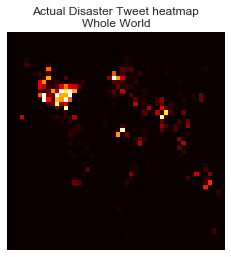

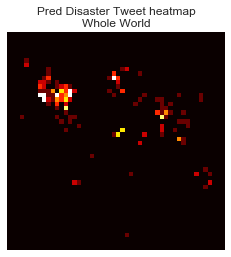

In [20]:
# Whole World
lons = (-180, 180)
lats = ( -90,  90)

dimensions = (50,50)
vmax = 7

img = locations_to_heatmap(real_disaster_coords,*lons,*lats,*dimensions)
plot_heatmap(img, title='Actual Disaster Tweet heatmap\nWhole World',
             vmax=vmax/frac_test,cmap='hot', interpolation='nearest')

img = locations_to_heatmap(pred_disaster_coords,*lons,*lats,*dimensions)
plot_heatmap(img, title='Pred Disaster Tweet heatmap\nWhole World',
             vmax=vmax,cmap='hot', interpolation='nearest')

### The United States

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


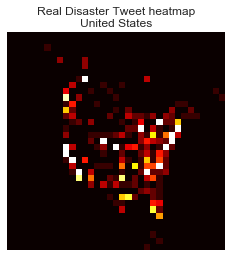

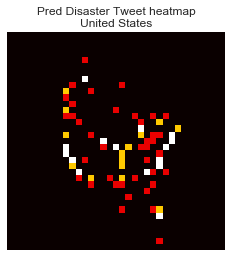

In [21]:
# United States
lons = (-150, -50)
lats = (  20,  60)

dimensions = (35,35)
vmax = 3

img = locations_to_heatmap(real_disaster_coords,*lons,*lats,*dimensions)
plot_heatmap(img, title='Real Disaster Tweet heatmap\nUnited States',
             vmax=vmax/frac_test,cmap='hot', interpolation='nearest')
             
img = locations_to_heatmap(pred_disaster_coords,*lons,*lats,*dimensions)
plot_heatmap(img, title='Pred Disaster Tweet heatmap\nUnited States',
             vmax=vmax,cmap='hot', interpolation='nearest')

### Florida

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


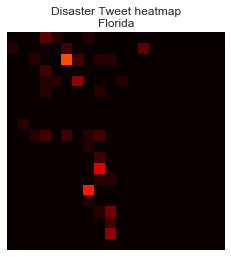

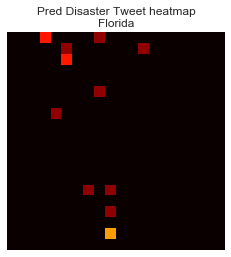

In [22]:
# Florida
lons = (-90, -70)
lats = ( 25,  35)

dimensions = (20,20)
vmax = 5

img = locations_to_heatmap(real_disaster_coords,*lons,*lats,*dimensions)
plot_heatmap(img, title='Disaster Tweet heatmap\nFlorida',
             vmax=vmax/frac_test,cmap='hot', interpolation='nearest')

img = locations_to_heatmap(pred_disaster_coords,*lons,*lats,*dimensions)
plot_heatmap(img, title='Pred Disaster Tweet heatmap\nFlorida',
             vmax=vmax,cmap='hot', interpolation='nearest')

In [23]:
m = leaf.Map(center=(30, 0), zoom=2, basemap = basemaps.Esri.DeLorme)

geolocations = []
geolocationsReal = []

#print(pred_disaster_coords[0])
#print(real_disaster_coords[0])

#print(pred_disaster_tweets[0])
#print(real_disaster_tweets[0])

Prediction = LayerGroup(name='Predicted Disasters')
Actual = LayerGroup(name='Actual Disasters')
Prediction.clear_layers()
Actual.clear_layers()

for i in range(np.shape(pred_disaster_coords)[0]):
    lat = pred_disaster_coords[i][1]
    lon = pred_disaster_coords[i][0]
    
    geolocations.append([lat,lon])
    tweetPred = 'Tweet: %s     (COUNTRY CODE: %s)'%(pred_disaster_tweets[i][0],pred_disaster_tweets[i][3])
    
    mark = Marker(location=geolocations[i], draggable=False, title = tweetPred)
    mark.popup = HTML(tweetPred)
        
    Prediction.add_layer(mark)
    
for i in range(np.shape(real_disaster_coords)[0]):   
    lat_real = real_disaster_coords[i][1]
    lon_real = real_disaster_coords[i][0]
    
    geolocationsReal.append([lat_real,lon_real])
    
    tweetReal = "Tweet: %s     (COUNTRY CODE: %s)"%(real_disaster_tweets[i][0],real_disaster_tweets[i][3])
    
    markReal = CircleMarker(location=geolocationsReal[i], radius = 3, color = "purple", fill_color = "purple")
    
    markReal.popup = HTML(tweetReal)
        
    Actual.add_layer(markReal)  
    
m.add_layer(Prediction)
m.add_layer(Actual)

#print(geolocationsReal[200])
#print(real_disaster_tweets[200])

control = LayersControl(position='topright')
m.add_control(control)

print("PREDICTED DISASTERS BASED ON TWEETS: ")
print("    Note: click on markers to read corresponding tweet.")

m

PREDICTED DISASTERS BASED ON TWEETS: 
    Note: click on markers to read corresponding tweet.


Map(center=[30, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [24]:
#https://python-visualization.github.io/folium/modules.html
from folium.plugins import MarkerCluster
locator = Nominatim(user_agent="myGeocoder", timeout=5)

folium_map = folium.Map(location=[30, 0], zoom_start=2)
mc = MarkerCluster()

address = []
for i in range(np.shape(real_disaster_coords)[0]):
    lat = real_disaster_coords[i][1]
    lon = real_disaster_coords[i][0]
    
    #coordinates = "{:.7f}, {:.7f}".format(lat,lon)
    #location = locator.reverse(coordinates)
    #address.append(location.address)
    
    mc.add_child(folium.Marker(location=[lat, lon], popup = real_disaster_tweets[i]) )
    
folium_map.add_child(mc)
folium_map.save('GeoLocation-REAL.html')

print("GIS for REAL DISASTER EVENTS by REGION/ZONE: ")
folium_map

GIS for REAL DISASTER EVENTS by REGION/ZONE: 


# Conclusion
---

The three visualizations allowed us to spatially compare the accuracy of our model at different levels. The first series of heat maps indicated that our model matches the general shape of the real disaster data but lacked density.  To verify this inference, we looked further at the two interactive maps. As a result, we quickly found the location of the user might not match the location of the crisis mentioned in the tweet. We were also able to read tweets and understand that our model doesn’t provide insight into timing. Additionally, several predicted tweets did not seem relevant at all, meaning that false positives are still a risk.


# Next Steps

## 01. Reverse Geocoding


We can specify a Geocoding service, like 'google', 'bing', 'yahoo'and 'openmapquest.' Some charge a fee after a specific limit, but we can also use a free Geocoding service with Openstreetmap. We could define a function like:

def findAddress(lat, lon):
> geolocator = Nominatim(user_agent=”myGeocoder”) <br>
> reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1) <br>
> coordinates = “{.7f}, {.7f}”.(lat, lon) <br>
> location = locator.reverse(coordinates) <br>
> location.raw <br>
> return location.address

Once we provide the coordinates (lat, lon) the geocoder provides a dictionary of different features like building name, city, state, etc. See example below for one of the tweets. With a bulk of data, we would need a higher limit for requests to this API.

In [24]:
from geopy.extra.rate_limiter import RateLimiter

def findAddress(lat, lon, tweet):
    geolocator = Nominatim(user_agent="myGeocoder")
    reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)
    coordinates = "{}, {}".format(lat, lon)
    #print(coordinates)
    location = locator.reverse((coordinates),language='en',exactly_one=True)
    #print(location.raw)
    print("TWEET: ", tweet)
    return location.address

#findAddress(pred_disaster_coords[i][1],pred_disaster_coords[i][0],pred_disaster_tweets[i])

import random
val = random.randint(0,np.shape(pred_disaster_coords)[0]-1)

print("Index val: ", val)
latZero = pred_disaster_coords[val][1]
lonZero = pred_disaster_coords[val][0]
tweetZero = pred_disaster_tweets[val]

findAddress(latZero,lonZero,tweetZero)

Index val:  243
TWEET:  ['Major accident causes life-threatening injuries closes highway: An 18-wheeler and an SUV collided and then\x89Û_ http://t.co/ajTXUafOEM'
 31.571820000000056 -97.1495 'USA' 'Waco']


'428, Herring Avenue, Waco, McLennan County, Texas, 76708, United States of America'

## 02. COVID-19 Application

We would like to pilot this in the context of an actual food disaster, particularly during this COVID-19 pandemic. We would like to use this model to collect and process real-time data from tweets to identify where food resources are needed most. It would be interesting on how we could incorporate more formalized data sources that currently track coronavirus cases at a national or regional level, like John Hopkins Public Health.

John Hopkins Public Health — COVID-19 Global Data: 
- https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
- https://www.tableau.com/covid-19-coronavirus-data-resources

# References


\[**original.csv** - https://data.world/crowdflower/disasters-on-social-media \]
This is the original tweet data that was used to generate the kaggle dataset.

\[**train.csv and test.csv** - https://www.kaggle.com/c/nlp-getting-started/data \]
The direct translation of the information in _original.csv_ such that it's formatted a bit more easily and can be submitted for the kaggle competition

\[**geodata.csv** - 
https://www.kaggle.com/frednavruzov/disaster-tweets-geodata \]
The tweet dataset from original.csv but with actual geolocations that have been cleaned up